In [1]:
import numpy as np
import pickle
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

In [2]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
class CocoDataset(Dataset):
    """ Our custom Coco Dataset """
    
    def __init__(self, matrix, person, transform=None):
        self.matrix = matrix
        self.transform = transform
        self.person = person
        
    def __len__(self):
        return len(self.matrix)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.matrix[idx]
        person = self.person[idx]

        if self.transform:
            sample = (self.transform(Image.fromarray(sample[0]).convert('LA'))[0].unsqueeze(0), person)
        else:
            sample = (Image.fromarray(sample[0]).convert('LA')[0].unsqueeze(0), person)

        return sample

In [4]:
person_pkl = open('./files/COCO/personimages.pkl', 'rb')
person_matrix = pickle.load(person_pkl)

In [5]:
person_dataset = CocoDataset(person_matrix,
                             transform=torchvision.transforms.Compose([
                                   torchvision.transforms.Resize((28, 28)),
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.1307, ), (0.3081,))
                             ]),
                             person=np.ones(120))

In [6]:
no_person_pkl = open('./files/COCO/nopersonimages.pkl', 'rb')
no_person_matrix = pickle.load(no_person_pkl)

In [7]:
no_person_dataset = CocoDataset(no_person_matrix,
                             transform=torchvision.transforms.Compose([
                                   torchvision.transforms.Resize((28, 28)),
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.1307, ), (0.3081,))
                             ]),
                             person=np.zeros(120))

In [8]:
people_dataset = CocoDataset(person_matrix + no_person_matrix,
                             transform=torchvision.transforms.Compose([
                                   torchvision.transforms.Resize((28, 28)),
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.1307, ), (0.3081,))
                             ]),
                             person=np.concatenate((np.ones(120, dtype=np.int_), np.zeros(120, dtype=np.int_)))
                            )

In [9]:
batch_size_train = 10
person_train_loader = torch.utils.data.DataLoader(
    person_dataset,
    batch_size=batch_size_train, 
    shuffle=True
)
no_person_train_loader = torch.utils.data.DataLoader(
    no_person_dataset,
    batch_size=batch_size_train,
    shuffle=True
)

In [10]:
batch_size_train = 60
batch_size_test = 120
people_train_loader = torch.utils.data.DataLoader(
    people_dataset,
    batch_size=batch_size_train,
    shuffle=True
)
people_test_loader = torch.utils.data.DataLoader(
    people_dataset,
    batch_size=batch_size_test,
    shuffle=True
)

In [11]:
examples = enumerate(people_train_loader)
batch_idx, (example_data, example_targets) = next(examples)

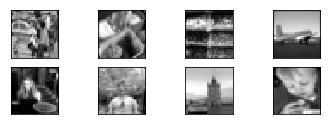

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure()

for i in range(8):
    plt.subplot(4,4,i+1)
    plt.imshow(example_data[i][0], cmap="gray", interpolation="none")
    plt.xticks([])
    plt.yticks([])

plt.show()

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    


In [117]:
learning_rate = 0.01
epochs = 100
log_interval = 10


network = Net().to("cpu")
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

In [118]:
def train(device):
    network.train() #set network to training mode
        
    batch_idx = -1
    for (data, target) in people_train_loader:
        batch_idx += 1
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        print('Train Epoch: {} [{}/{} ({:.2f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(people_train_loader.dataset),
            100. * batch_idx / len(people_train_loader), loss.item()
        ))

In [119]:
test_losses = []

def test(device):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in people_test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        num_samples = len(people_test_loader.dataset)
        test_loss /= num_samples
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, correct, num_samples,
                100. * correct / num_samples))

In [120]:
import time
start_time = time.time()

test("cpu")
for epoch in range(epochs):
    train("cpu")
    test("cpu")
    
print("CPU took %s seconds" % (time.time() - start_time))

/home/davidzchen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3497, Accuracy: 0/240 (0%)

Train Epoch: 0 [0/240 (0.00%)]	Loss: 2.362829
Train Epoch: 0 [60/240 (25.00%)]	Loss: 2.329947
Train Epoch: 0 [120/240 (50.00%)]	Loss: 2.299446
Train Epoch: 0 [180/240 (75.00%)]	Loss: 2.303264

Test set: Avg. loss: 2.2668, Accuracy: 26/240 (11%)

Train Epoch: 1 [0/240 (0.00%)]	Loss: 2.264652
Train Epoch: 1 [60/240 (25.00%)]	Loss: 2.231156
Train Epoch: 1 [120/240 (50.00%)]	Loss: 2.228245
Train Epoch: 1 [180/240 (75.00%)]	Loss: 2.206429

Test set: Avg. loss: 2.1697, Accuracy: 119/240 (50%)

Train Epoch: 2 [0/240 (0.00%)]	Loss: 2.165452
Train Epoch: 2 [60/240 (25.00%)]	Loss: 2.171052
Train Epoch: 2 [120/240 (50.00%)]	Loss: 2.107522
Train Epoch: 2 [180/240 (75.00%)]	Loss: 2.095035

Test set: Avg. loss: 2.0253, Accuracy: 120/240 (50%)

Train Epoch: 3 [0/240 (0.00%)]	Loss: 2.041646
Train Epoch: 3 [60/240 (25.00%)]	Loss: 1.975019
Train Epoch: 3 [120/240 (50.00%)]	Loss: 1.903116
Train Epoch: 3 [180/240 (75.00%)]	Loss: 1.846843

Test set: Avg. 


Test set: Avg. loss: 0.7102, Accuracy: 120/240 (50%)

Train Epoch: 33 [0/240 (0.00%)]	Loss: 0.723665
Train Epoch: 33 [60/240 (25.00%)]	Loss: 0.732094
Train Epoch: 33 [120/240 (50.00%)]	Loss: 0.748006
Train Epoch: 33 [180/240 (75.00%)]	Loss: 0.726980

Test set: Avg. loss: 0.6946, Accuracy: 122/240 (51%)

Train Epoch: 34 [0/240 (0.00%)]	Loss: 0.717126
Train Epoch: 34 [60/240 (25.00%)]	Loss: 0.708420
Train Epoch: 34 [120/240 (50.00%)]	Loss: 0.824181
Train Epoch: 34 [180/240 (75.00%)]	Loss: 0.701561

Test set: Avg. loss: 0.7087, Accuracy: 120/240 (50%)

Train Epoch: 35 [0/240 (0.00%)]	Loss: 0.685566
Train Epoch: 35 [60/240 (25.00%)]	Loss: 0.732671
Train Epoch: 35 [120/240 (50.00%)]	Loss: 0.773385
Train Epoch: 35 [180/240 (75.00%)]	Loss: 0.701220

Test set: Avg. loss: 0.6907, Accuracy: 128/240 (53%)

Train Epoch: 36 [0/240 (0.00%)]	Loss: 0.728342
Train Epoch: 36 [60/240 (25.00%)]	Loss: 0.699562
Train Epoch: 36 [120/240 (50.00%)]	Loss: 0.703207
Train Epoch: 36 [180/240 (75.00%)]	Loss: 0.711

Train Epoch: 65 [180/240 (75.00%)]	Loss: 0.757446

Test set: Avg. loss: 0.6930, Accuracy: 125/240 (52%)

Train Epoch: 66 [0/240 (0.00%)]	Loss: 0.701794
Train Epoch: 66 [60/240 (25.00%)]	Loss: 0.683792
Train Epoch: 66 [120/240 (50.00%)]	Loss: 0.725410
Train Epoch: 66 [180/240 (75.00%)]	Loss: 0.763817

Test set: Avg. loss: 0.6869, Accuracy: 134/240 (56%)

Train Epoch: 67 [0/240 (0.00%)]	Loss: 0.698370
Train Epoch: 67 [60/240 (25.00%)]	Loss: 0.778660
Train Epoch: 67 [120/240 (50.00%)]	Loss: 0.726081
Train Epoch: 67 [180/240 (75.00%)]	Loss: 0.693724

Test set: Avg. loss: 0.6878, Accuracy: 128/240 (53%)

Train Epoch: 68 [0/240 (0.00%)]	Loss: 0.693634
Train Epoch: 68 [60/240 (25.00%)]	Loss: 0.692322
Train Epoch: 68 [120/240 (50.00%)]	Loss: 0.731532
Train Epoch: 68 [180/240 (75.00%)]	Loss: 0.730337

Test set: Avg. loss: 0.6853, Accuracy: 122/240 (51%)

Train Epoch: 69 [0/240 (0.00%)]	Loss: 0.707261
Train Epoch: 69 [60/240 (25.00%)]	Loss: 0.723343
Train Epoch: 69 [120/240 (50.00%)]	Loss: 0.722

Train Epoch: 98 [180/240 (75.00%)]	Loss: 0.741828

Test set: Avg. loss: 0.6832, Accuracy: 139/240 (58%)

Train Epoch: 99 [0/240 (0.00%)]	Loss: 0.700551
Train Epoch: 99 [60/240 (25.00%)]	Loss: 0.710874
Train Epoch: 99 [120/240 (50.00%)]	Loss: 0.715164
Train Epoch: 99 [180/240 (75.00%)]	Loss: 0.714782

Test set: Avg. loss: 0.6823, Accuracy: 140/240 (58%)

CPU took 119.34361600875854 seconds
